# IMDB movie review sentiment analysis

## Basic steps for NLP

1. Prepare the input
  - Tokenize the words
  - Build the vocabulary which maps word to id
  - Also build id_to_word dict to map id back to word
  - Pad/truncate the sentences to a fixed length
  
2. Build/train model using keras
  - Add layers (width, activation, dropout)
  - Defind loss and optimizer
  - Dertermine # of epochs and # of mini-batches

3. Evalute the model
  - Plot loss/accuracy vs # of epochs
  - Output the loss/accuracy on the test data
  
4. Improvements
  - Make the neural net deeper by adding more LSTM layers
  - Use bidirectional LSTM
  - Use pre-trained embeddings

In [1]:
# Import moduals

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import Sequential
from keras.layers import  Embedding, Bidirectional, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM
from keras.regularizers import l1, l2

print (tf.__version__)

1.12.0


Using TensorFlow backend.


## 1. Load and prepare the data for input

In [0]:
from keras.datasets import imdb

vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

### Build the vocabulary

We can get the vocabulary which is a dictionary mapping word to id using the fuction get_word_index(). However, we also want to add the special symbols which represent the *Start-of-sentence* 'SOS', *Padding* 'PAD', and *Word-not-in-vocab* 'UNK' to the vocabulary.


In [0]:
word_to_index = imdb.get_word_index()

word_to_index = dict([(k, v+3) for (k,v) in word_to_index.items()])
word_to_index['<PAD>'] = 0
word_to_index['<SOS>'] = 1
word_to_index['<UNK>'] = 2

### Get the reverse mapping from id to word

In [0]:
index_to_word = dict([(v, k) for (k, v) in word_to_index.items()])

Define a function to transfrom the tokenized sentence to the sentence text.

In [0]:
def to_text(tokens):
  
  sentence = [index_to_word.get(token, '<UNK>') for token in tokens]
  print_text = []
  for idx, word in enumerate(sentence):
    print_text.append(word)
    if (idx + 1) % 10 == 0:
      print_text.append('\n')
  
  print(' '.join(print_text))

In [6]:
to_text(X_train[0])

<SOS> this film was just brilliant casting location scenery story 
 direction everyone's really suited the part they played and you 
 could just imagine being there robert <UNK> is an amazing 
 actor and now the same being director <UNK> father came 
 from the same scottish island as myself so i loved 
 the fact there was a real connection with this film 
 the witty remarks throughout the film were great it was 
 just brilliant so much that i bought the film as 
 soon as it was released for <UNK> and would recommend 
 it to everyone to watch and the fly fishing was 
 amazing really cried at the end it was so sad 
 and you know what they say if you cry at 
 a film it must have been good and this definitely 
 was also <UNK> to the two little boy's that played 
 the <UNK> of norman and paul they were just brilliant 
 children are often left out of the <UNK> list i 
 think because the stars that play them all grown up 
 are such a big profile for the whole film but 
 these children are ama

### Pad/truncate the sentences to a fixed length

We pad the short sentences from the beginning due to the fact that if we do this from the end, the previous words will get forgorten during the training. And we also truncate the long sentences from the beginning since people tend to say important things in the later part.

In [7]:
len(X_train[0]) ,len(X_train[1])

(218, 189)

We want the length of the sentence to be 100.

In [0]:
from keras.preprocessing.sequence import pad_sequences

max_len = 100
X_train = pad_sequences(X_train,
                        value = word_to_index['<PAD>'],
                        padding = 'pre',
                        truncating = 'pre',
                        maxlen = max_len
                       )

X_test = pad_sequences(X_test,
                        value = word_to_index['<PAD>'],
                        padding = 'pre',
                        truncating = 'pre',
                        maxlen = max_len
                       )

In [9]:
len(X_train[0]) ,len(X_train[1])

(100, 100)

In [10]:
to_text(X_train[0])

cry at a film it must have been good and 
 this definitely was also <UNK> to the two little boy's 
 that played the <UNK> of norman and paul they were 
 just brilliant children are often left out of the <UNK> 
 list i think because the stars that play them all 
 grown up are such a big profile for the whole 
 film but these children are amazing and should be praised 
 for what they have done don't you think the whole 
 story was so lovely because it was true and was 
 someone's life after all that was shared with us all 



In [11]:
to_text(X_train[5])

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <SOS> begins better 
 than it ends funny that the russian submarine crew <UNK> 
 all other actors it's like those scenes where documentary shots 
 br br spoiler part the message <UNK> was contrary to 
 the whole story it just does not <UNK> br br 



In [12]:
X_train[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1,  778,  128,   74,   12,  630,  163,   15,    4,
       1766, 7982, 1051,    2,   32,   85,  156,   45,   40,  148,  139,
        121,  664,  665,   10,   10, 1361,  173,    4,  749,    2,   16,
       3804,    8,    4,  226,   65,   12,   43,  127,   24,    2,   10,
         10], dtype=int32)

## Build and train the models for sentiment prediction

We will try several different models to compare the result and performance.
  - A feed-forward NN with 1 embedding layer, 1 globalaverageplooing1D, 1 hidden layer and 1 'softmax' layer for the output.
  - A RNN using cuDNNLSTM.
  - Add one more LSTM layer to the previous model.
  - Use bidirectional LSTM and also try pre-trained embeddings.

### Define the functions to build, train and plot loss/accuracy for different models.

In [0]:
def build_FNN():
  # Add dropout to reduce overfitting
  dropout_rate = 0.8
  
  model = Sequential()
  # The embedding layer, 100 is the embedding dimension
  model.add(Embedding(vocab_size, 100))
  # The globalaveragepooling to flatten the result
  model.add(GlobalAveragePooling1D())
  # A dense layer of width 16 and the output layer with 1 node
  #model.add(Dense(128, activation='relu'))
  #if dropout_rate > 0:
  #  model.add(Dropout(dropout_rate))
  #model.add(Dense(1, activation='sigmoid'))
  model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
  if dropout_rate > 0:
    model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='sigmoid'))
  
  # Define the loss and optimizer for the model
  model.compile(loss = 'binary_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy']
               )
  
  print(model.summary())
  return model

def build_RNN():
  
  model = Sequential()
  
  model.add(Embedding(vocab_size, 100))
  # For the LSTM we just need to define the memory width
  #model.add(CuDNNLSTM(32))
  model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss = 'binary_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy']
               )
  
  print(model.summary())
  return model

def build_deeper_RNN():
  
  model = Sequential()
  
  model.add(Embedding(vocab_size, 100))
  # We need to set return_sequences = True for all the LSTM layers but the last one
  model.add(LSTM(32, return_sequences=True))
  model.add(LSTM(32, return_sequences=False))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss = 'binary_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy']
               )
  
  print(model.summary())
  return model

def build_biDirec_RNN():
  
  model = Sequential()
  
  model.add(Embedding(vocab_size, 100))
  
  model.add(Bidirectional(LSTM(32)))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss = 'binary_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy']
               )
  
  print(model.summary())
  return model

In [0]:
def train_model(model, num_epochs, num_batchs):
  
  history = model.fit(X_train[:10000],
                      y_train[:10000],
                      epochs = num_epochs,
                      batch_size = num_batchs,
                      validation_data = (X_train[10000:12000], y_train[10000:12000])
                     )
  return history

In [0]:
def plot_history(history, num_epochs):
  
  history = history.history
  
  train_loss = history['loss']
  train_acc = history['acc']
  val_loss = history['val_loss']
  val_acc = history['val_acc']
  
  x_axis = [i+1 for i in range(num_epochs)]
  
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  
  ax[0].plot(x_axis, train_loss, 'bo', label='Training loss')
  ax[0].plot(x_axis, val_loss, 'r', label='Validation loss')
  ax[0].set_title('Training/Validatin loss vs # of epochs')
  ax[0].set_xlabel('# of epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  
  ax[1].plot(x_axis, train_acc, 'bo', label='Training accuracy')
  ax[1].plot(x_axis, val_acc, 'r', label='Validation accuracy')
  ax[1].set_title('Training/Validatin accuracy vs # of epochs')
  ax[1].set_xlabel('# of epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()
  
  plt.show()

### The feed-forward NN

In [16]:
model = build_FNN()
history = train_model(model, 10, 128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________
None
Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 158us/step - loss

In [17]:
model.evaluate(X_test, y_test)

25000/25000 [==============================] - 1s 59us/step


[0.4106702568912506, 0.84164]

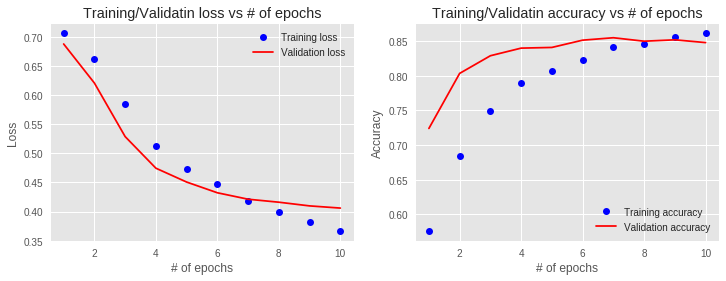

In [18]:
plot_history(history, 10)

### RNN (1 LSTM layer, 2 LSTM layers, bidirenctional LSTM)

In [19]:
model = None
model = build_RNN()
history = train_model(model, 5, 128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
None
Train on 10000 samples, validate on 2000 samples
Epoch 1/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.6633 - acc: 0.6147 - val_loss: 0.5688 - val_acc: 0.7525
Epoch 2/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.4992 - acc: 0.7777 - val_loss: 0.4616 - val_acc: 0.7915
Epoch 3/5
10000/10000 [==============================] - 23s 2ms/step 

In [20]:
model.evaluate(X_test, y_test)

25000/25000 [==============================] - 59s 2ms/step


[0.4815567259025574, 0.77748]

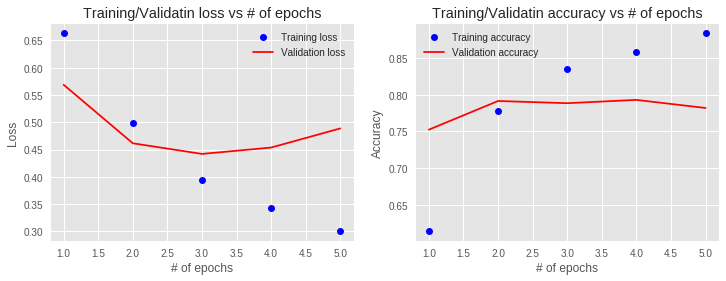

In [21]:
plot_history(history, 5)

Add one more LSTM layer

In [22]:
model = build_deeper_RNN()
history = train_model(model, 5, 128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          17024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,025,377
Trainable params: 1,025,377
Non-trainable params: 0
_________________________________________________________________
None
Train on 10000 samples, validate on 2000 samples
Epoch 1/5
10000/10000 [==============================] - 41s 4ms/step - loss: 0.5729 - acc: 0.6922 - val_loss: 0.4426 - val_acc: 0.7990
Epoch 2/5
10000/10000 [==============================] - 39s 4ms/step - lo

In [23]:
model.evaluate(X_test, y_test)

25000/25000 [==============================] - 92s 4ms/step


[0.5625864365768433, 0.81524]

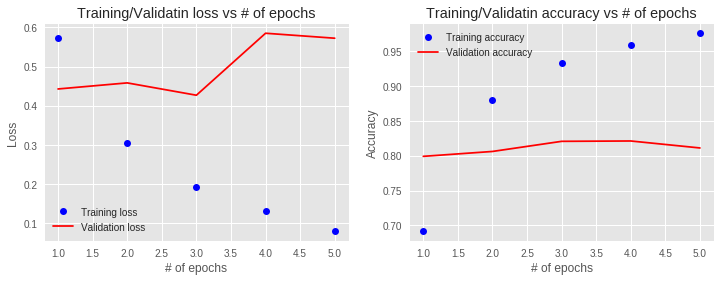

In [24]:
plot_history(history, 5)

Bidirectional LSTM

In [25]:
model = build_deeper_RNN()
history = train_model(model, 5, 128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          17024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,025,377
Trainable params: 1,025,377
Non-trainable params: 0
_________________________________________________________________
None
Train on 10000 samples, validate on 2000 samples
Epoch 1/5
10000/10000 [==============================] - 41s 4ms/step - loss: 0.5650 - acc: 0.6788 - val_loss: 0.4188 - val_acc: 0.8170
Epoch 2/5
10000/10000 [==============================] - 39s 4ms/step - lo

In [26]:
model.evaluate(X_test, y_test)

25000/25000 [==============================] - 95s 4ms/step


[0.6037913410902024, 0.81416]

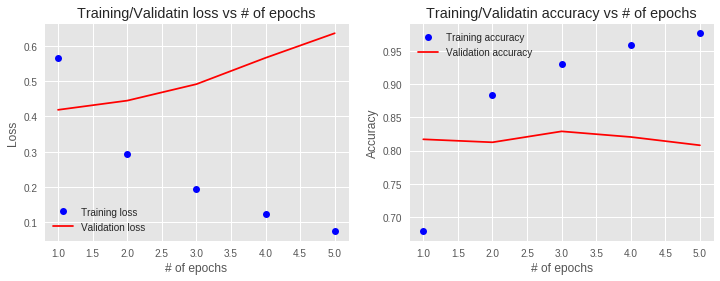

In [27]:
plot_history(history, 5)

### Use the pre-trained embedding

Do it on Mac



In [28]:
!kaggle datasets download -d terenceliu4444/glove6b100dtxt
!unzip glove6b100dtxt.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 113, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open glove6b100dtxt.zip, glove6b100dtxt.zip.zip or glove6b100dtxt.zip.ZIP.


## Appendix: Setup Kaggle on Google colab

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
k_config = files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [0]:
!kaggle datasets download -d terenceliu4444/glove6b100dtxt
!unzip glove6b100dtxt.zip